## This is a copy of another notebook but with slightly different restriction of matches (e.g. 300kpc radius)

In [1]:
# Imports
import numpy as np # math and arrays
import healpy as hp # plotting and coordinates

import astropy.units as u # units for conversion and stuff
import matplotlib.pyplot as plt # plots#

from astropy.table import Table # reading and storing data
from astropy.coordinates import SkyCoord, Angle # crossmatching and plotting
from astropy.cosmology import Planck18 as cosmo # cosmology for radius check

from healpy.newvisufunc import projview, newprojplot


# Loading Data

### X-ray Quasars

Load in check structure of table that was produced in another notebook.

In [2]:
quasars_table = Table.read("../Products/Tables/matched_quaia.csv")
print(f"{len(quasars_table)} X-ray Quasars")
quasars_table[0:3]

40511 X-ray Quasars


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err
str23,int64,float64,float64,float64,float64,float64,int64,float64,float64
1eRASS J002937.2-310209,100912000003,7.405248991349619,-31.036102555952215,1.2771693468093872,0.0,1.5508954797488483e-12,2317512508372225024,0.282,0.1090472537279129
1eRASS J012338.1-231059,102111400001,20.90908484230626,-23.183134713205,1.2023203372955322,0.0,1.1919692663453496e-11,5041410282510663168,0.39622849225997925,0.13338495750904084
1eRASS J020037.2-164905,103010800001,30.155090369271388,-16.818333184496638,0.6730599999427795,0.0,2.485978436994607e-12,5141673064220360320,0.3344,0.14063352643013


I will keep all the columns here, as there are not that many and all could be useful.<br>
If I require extra info, I should modify the notebook that produces this.

### eRASS Clusters

Load in and check structure of table.<br>
This table can be downloaded from the [eROSITA DR1 Website](https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/Catalogues_dr1/)

In [3]:
clusters_table_full = Table.read("../Data/erass1cl_primary_v3.2.fits")
print(f"{len(clusters_table_full)} Cluster")
clusters_table_full[0:3]

12247 Cluster


DETUID,NAME,RA,DEC,RA_XFIT,DEC_XFIT,EXT_LIKE,DET_LIKE_0,EXP,BEST_Z,BEST_ZERR,BEST_Z_TYPE,PCONT,CR300kpc,CR300kpc_L,CR300kpc_H,CR500,CR500_L,CR500_H,CTS300kpc,CTS300kpc_L,CTS300kpc_H,CTS500,CTS500_L,CTS500_H,F300kpc,F300kpc_L,F300kpc_H,F500,F500_L,F500_H,L300kpc,L300kpc_L,L300kpc_H,L500,L500_L,L500_H,CR300kpc0520,CR300kpc_L0520,CR300kpc_H0520,CR500_0520,CR500_L_0520,CR500_H_0520,CTS300kpc0520,CTS300kpc_L0520,CTS300kpc_H0520,CTS500_0520,CTS500_L_0520,CTS500_H_0520,F300kpc0520,F300kpc_L0520,F300kpc_H0520,F500_0520,F500_L_0520,F500_H_0520,L300kpc0520,L300kpc_L0520,L300kpc_H0520,L500_0520,L500_L_0520,L500_H_0520,Lbol500,Lbol500_L,Lbol500_H,KT,KT_L,KT_H,MGAS500,MGAS500_L,MGAS500_H,YX500,YX500_L,YX500_H,M500,M500_L,M500_H,FGAS500,FGAS500_L,FGAS500_H,R500,R500_L,R500_H,MATCH_NAME,M500_PDF,M500_PDF_array
,,deg,deg,deg,deg,,,,,,,,1 / s,1 / s,1 / s,1 / s,1 / s,1 / s,,,,,,,1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1 / s,1 / s,1 / s,1 / s,1 / s,1 / s,,,,,,,1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e-14 erg / (s cm2),1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,1e+42 erg / s,keV,keV,keV,1e+11 solMass,1e+11 solMass,1e+11 solMass,1e+11 keV solMass,1e+11 keV solMass,1e+11 keV solMass,1e+13 solMass,1e+13 solMass,1e+13 solMass,,,,kpc,kpc,kpc,,,solMass
bytes32,bytes23,float64,float64,float64,float64,float32,float32,float32,float64,float64,bytes16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes240,float64[200],float64[200]
em01_002129_020_ML00014_002_c010,1eRASS J000005.2-383729,0.021729666982255817,-38.6249030550687,0.0214,-38.625,9.634506,80.58653,94.8,0.3153,0.0079,photo_z,0.006,0.352,0.287,0.434,0.509,0.404,0.627,33.4,27.2,41.1,48.2,38.3,59.4,32.51,26.686,39.709,47.11,37.15,57.854,97.485,78.312,119.878,140.172,111.091,173.67,0.276,0.225,0.339,0.4,0.316,0.49,26.1,21.3,32.2,37.9,30.0,46.4,23.137,19.103,28.383,33.653,26.557,41.195,66.955,53.625,82.239,96.23,76.158,119.632,253.286,196.126,349.587,1.9,1.37,3.53,279.16,209.64,328.65,553.19,348.81,964.03,36.07,29.45,44.96,0.075,0.054,0.102,971.0,908.0,1045.0,"ACTDR5_ACT-CL J0000.0-3837,SPTECS_J0000-3838",5.851765968674475e-18 .. 3.9392481575469995e-11,999999999999.999 .. 9999999999999964.0
em01_011174_020_ML00047_002_c010,1eRASS J000021.4-824954,0.08919076582988208,-82.83171519254894,0.0558,-82.8189,14.928127,37.221573,184.2,0.0891,0.0002,cg_spec_z,0.0,0.699,0.628,0.774,1.029,0.926,1.149,128.8,115.6,142.6,189.5,170.6,211.6,66.773,60.058,74.071,98.355,88.515,109.715,16.881,15.108,18.682,24.747,22.321,27.683,0.603,0.541,0.668,0.887,0.799,0.99,111.0,99.6,123.0,163.3,147.1,182.4,53.122,47.819,58.881,78.328,70.466,87.401,11.653,10.43,12.911,17.115,15.439,19.131,76.492,53.559,123.554,-1.0,3.82,-1.0,111.92,96.52,125.58,-0.0,-0.0,-0.0,16.99,15.65,18.85,0.065,0.055,0.076,819.0,796.0,847.0,,4.8286962310633425e-14 .. 7.862194469501027e-15,999999999999.999 .. 9999999999999964.0
em01_002141_020_ML00031_002_c010,1eRASS J000031.0-500903,0.1294219086203196,-50.151012746035505,0.1305,-50.1515,6.9752207,46.228764,117.3,0.0681,0.0002,cg_spec_z,0.218,0.255,0.178,0.396,0.258,0.18,0.493,29.9,20.9,46.5,30.3,21.1,57.8,23.888,17.01,37.288,23.991,17.1,45.932,2.816,1.984,4.374,2.862,1.996,5.454,0.203,0.143,0.318,0.206,0.144,0.393,23.8,1

Select the columns I will require (I think) <br>

- NAME
- RA
- DEC
- BEST_Z
- R500

In [4]:
clusters_table = clusters_table_full['NAME', 'RA', 'DEC', 'BEST_Z', 'R500']
clusters_table[0:3]


NAME,RA,DEC,BEST_Z,R500
,deg,deg,,kpc
bytes23,float64,float64,float64,float64
1eRASS J000005.2-383729,0.021729666982255817,-38.6249030550687,0.3153,971.0
1eRASS J000021.4-824954,0.08919076582988208,-82.83171519254894,0.0891,819.0
1eRASS J000031.0-500903,0.1294219086203196,-50.151012746035505,0.0681,493.0


# Crossmatching

<!-- Some clusters have really rather large R500 values (e.g. Virgo Cluster), so use R500 value UPTO 300 kpc <br>
Calculate the R500 value of the clusters in terms of angle. -->
Work out angular separation of either 0.9*R500 OR 300kpc at redshift of cluster and take the minimum. <rb>

300 kpc is a good estimate for the core of most clusters and also the cluster catalogue provide the properties within 300kpc

In [5]:
clusters_table['R500_sep'] = cosmo.arcsec_per_kpc_proper(clusters_table['BEST_Z'])*np.minimum(0.9*clusters_table['R500'], u.Quantity(300, 'kpc'))

clusters_table['R500_sep'][0:5]


63.07747436174854
174.3890903041879
222.62168953100382
75.47179841738614
168.64431634978803


Crossmatching quasars to clusters, clusters could have multple quasars so important to do it this way round

In [6]:
cluster_coords = SkyCoord(ra=clusters_table['RA'], dec=clusters_table['DEC'])
quasar_coords = SkyCoord(ra=quasars_table['RA'], dec=quasars_table['DEC'], unit='deg')

idx, d2d, d3d = quasar_coords.match_to_catalog_sky(cluster_coords)

separation_condition = clusters_table[idx]['R500_sep'] > d2d
matched_ids = idx[separation_condition]

matched_quasars = quasars_table[separation_condition]

matched_quasars['CLUSTER_NAME'] = clusters_table[matched_ids]['NAME']
matched_quasars['SEPARATION'] = d2d[separation_condition]
print(f"{len(matched_quasars)} matched quasars to clusters")
matched_quasars[:3]

139 matched quasars to clusters


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err,CLUSTER_NAME,SEPARATION
,,,,,,,,,,,deg
str23,int64,float64,float64,float64,float64,float64,int64,float64,float64,bytes23,float64
1eRASS J034542.8-512950,105814100004,56.428536351919384,-51.49737416405309,0.8932768702507019,0.0,1.2494709043450736e-12,4829294973181982976,0.396,0.07660170276641848,1eRASS J034542.1-513042,0.014563502373970234
1eRASS J043829.2-614758,107315300001,69.62171465309667,-61.79967048220355,0.3404570519924164,0.0,4.316204078175234e-12,4677239112130585984,1.927,0.7133141228485108,1eRASS J043838.1-615107,0.055282362612759095
1eRASS J045957.6-611510,107715000001,74.99019789325905,-61.25294175144008,0.35830843448638916,0.0,2.8914154057146924e-12,4761465310590509056,0.16512604357212446,0.09792351691246033,1eRASS J045949.0-611349,0.028276261080173008


### Previously I removed clusters with many matches, but this time i will keep, particuarly as one is Virgo Cluster which may be a usefull comparision

Check how many unqiue clusters

In [7]:
unique_cluster, counts = np.unique(matched_quasars['CLUSTER_NAME'], return_counts=True)
len(unique_cluster)
print(counts)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 8 9 1 1 2 1 1 1 1 2 1 1 2 1 1 1 2 5 1 1 1 1 1]


Once cluster suposedly has 20 quasars, even after restricting max size... <br>
Seems to be partly due to very small redshift

In [8]:
clusters_table[clusters_table['NAME'] == unique_cluster[np.argmax(counts)]]

NAME,RA,DEC,BEST_Z,R500,R500_sep
,deg,deg,,kpc,arcsec
bytes23,float64,float64,float64,float64,float64
1eRASS J033829.1-352701,54.621377598493154,-35.45045581436987,0.005,575.0,2810.355920600135


### Redshift Checking

In [9]:
matched_quasars['CLUSTER_Z'] = clusters_table[matched_ids]['BEST_Z']
matched_quasars[0]

IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,QUAIA_source_id,QUAIA_redshift,QUAIA_redshift_err,CLUSTER_NAME,SEPARATION,CLUSTER_Z
,,,,,,,,,,,deg,
str23,int64,float64,float64,float64,float64,float64,int64,float64,float64,bytes23,float64,float64
1eRASS J034542.8-512950,105814100004,56.428536351919384,-51.49737416405309,0.8932768702507019,0.0,1.2494709043450736e-12,4829294973181982976,0.396,0.07660170276641848,1eRASS J034542.1-513042,0.014563502373970234,0.1939


Remove all quasars with a redshift+redshift_err less than the cluster

In [10]:
matched_quasars = matched_quasars[matched_quasars['QUAIA_redshift']+matched_quasars['QUAIA_redshift_err'] > matched_quasars['CLUSTER_Z']]
print(f"{len(matched_quasars)} Remaining quasars")

138 Remaining quasars


# Plotting

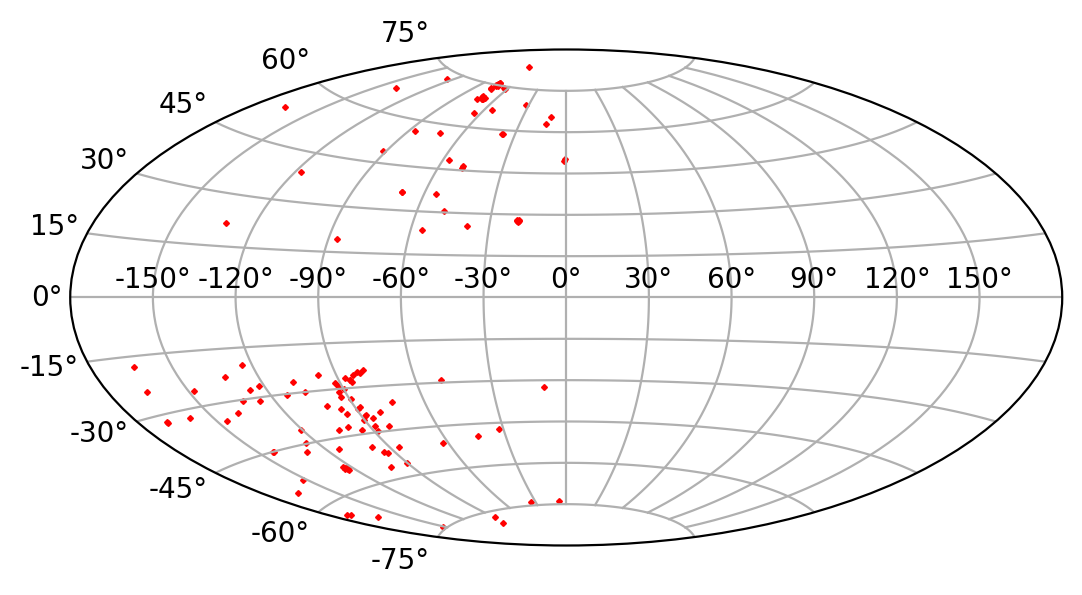

In [11]:
matched_coords = SkyCoord(ra=matched_quasars['RA'], dec=matched_quasars['DEC'], unit='deg')


ra = Angle(matched_coords.galactic.l).wrap_at(180*u.degree)
dec = Angle(matched_coords.galactic.b)

fig = plt.figure(dpi=200)
ax = fig.add_subplot(111, projection='aitoff')
ax.scatter(ra.radian, dec.radian, marker='x', s=2, c='r')
ax.grid(True)
plt.show()

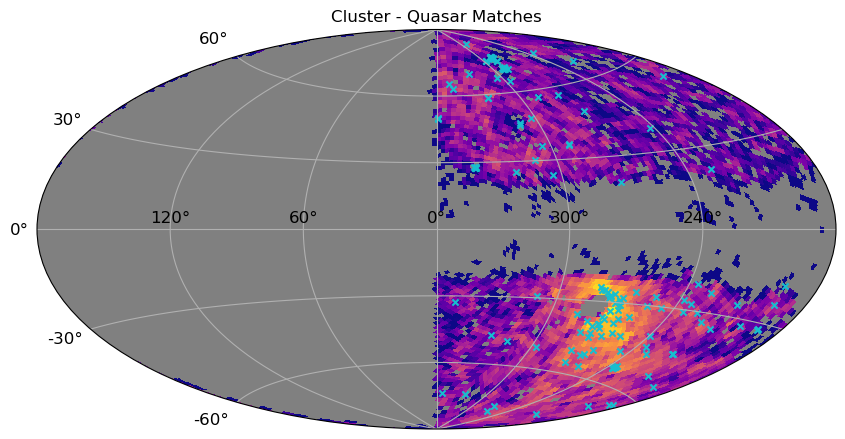

In [12]:
nside = 32
npix = hp.nside2npix(nside)

pixel_indices = hp.ang2pix(nside, clusters_table['RA'], clusters_table['DEC'], lonlat=True)
cluster_density = np.bincount(pixel_indices, minlength=npix)

mask = np.zeros(npix)

theta, phi = hp.pix2ang(nside, np.arange(npix), lonlat=True)
interp_val = hp.get_interp_val(cluster_density, theta, phi, lonlat=True)

mask[interp_val > 0] = 1

area = hp.nside2pixarea(nside, degrees=True)

smooth_cluster_density = mask * hp.smoothing(cluster_density, fwhm=np.radians(2))
smooth_cluster_density *= cluster_density.sum() / smooth_cluster_density.sum()

projview(smooth_cluster_density, coord=['C', 'G'], norm='log', min=1, graticule=True, graticule_labels=True, cmap="plasma", projection_type = "aitoff", cbar=False)
# theta = matched_quasars['RA']
# phi = matched_quasars['DEC']
theta = Angle(matched_coords.galactic.l)
phi = Angle(matched_coords.galactic.b)
# newprojplot(ra.radian[0], dec.radian[0], 'ro')
plt.scatter(-ra.radian, dec.radian, c='tab:cyan', marker='x', s=20)
# print(phi.degree)
plt.title("Cluster - Quasar Matches")
plt.savefig("../Products/Cluster_Quasars_matches_skyplot.png", dpi =400)
plt.show()

Save matched quasar clusters table for checking flux

In [13]:
matched_quasars.write("../Products/Tables/Cluster_Quasar_Matches_300kpc.csv", format="csv", overwrite=True)